In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

np.random.seed(123)
torch.manual_seed(123)

# Use some real data - Jiang et al

In [2]:
run_pgdl_da = np.load("../run-pgdl-da/2_model_prep/out/data_train[1985-05-01.2021-04-14]_1573.npz", allow_pickle=True)

In [3]:
x = torch.from_numpy(
    run_pgdl_da['x_trn_fine']
).float()
y = torch.from_numpy(
    run_pgdl_da['obs_trn']
).float()

# just use last year of data
x = x[:, -365:]
y = y[:, -365:]
y = (y - y.mean()) / y.std()

x.shape, y.shape

(torch.Size([31, 365, 6]), torch.Size([31, 365, 1]))

# Define a simple model

In [4]:
import torch
import torch.nn as nn
from typing import Dict
import time


# Simple LSTM made from scratch
#   Credit to / code modified from - https://towardsdatascience.com/building-a-lstm-by-hand-on-pytorch-59c02a4ec091
#   Associated github repo - https://github.com/piEsposito/pytorch-lstm-by-hand
class LSTMDA(nn.Module):
    def __init__(self, input_dim, hidden_dim, recur_dropout = 0, dropout = 0):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_size = hidden_dim
        # See the file "neuralnet_math_README.md" in the root directory for
        # equations and implementation details
        self.weight_ih = nn.Parameter(torch.Tensor(input_dim, hidden_dim * 4))
        self.weight_hh = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_dim * 4))
        self.init_weights()
        
        self.dropout = nn.Dropout(dropout)
        self.recur_dropout = nn.Dropout(recur_dropout)
    
    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
        
    def forward(self, x, init_states = None):
        """Assumes x is of shape (batch, sequence, feature)"""
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        if init_states is None:
            h_t, c_t = (torch.zeros(bs, self.hidden_size).to(x.device), 
                        torch.zeros(bs, self.hidden_size).to(x.device))
        else:
            h_t, c_t = init_states
        
        x = self.dropout(x)
        HS = self.hidden_size
        for t in range(seq_sz):
            x_t = x[:, t, :]
            # batch the computations into a single matrix multiplication
            gates = x_t @ self.weight_ih + h_t @ self.weight_hh + self.bias
            i_t, f_t, g_t, o_t = (
                torch.sigmoid(gates[:, :HS]), # input
                torch.sigmoid(gates[:, HS:HS*2]), # forget
                torch.tanh(gates[:, HS*2:HS*3]),
                torch.sigmoid(gates[:, HS*3:]), # output
            )
            c_t = f_t * c_t + i_t * self.recur_dropout(g_t)
            h_t = o_t * torch.tanh(c_t)
            hidden_seq.append(h_t.unsqueeze(1))
        hidden_seq = torch.cat(hidden_seq, dim= 1)
        return hidden_seq, (h_t, c_t)

# Credit to / code modified from https://github.com/neuralhydrology/neuralhydrology
class GMM(nn.Module):
    """Gaussian Mixture Density Network
    A mixture density network with Gaussian distribution as components. Good references are [#]_ and [#]_. The latter 
    one forms the basis for our implementation. As such, we also use two layers in the head to provide it with 
    additional flexibility, and exponential activation for the variance estimates and a softmax for weights.  
    Parameters
    ----------
    n_in : int
        Number of input neurons.
    n_out : int
        Number of output neurons. Corresponds to 3 times the number of components.
    n_hidden : int
        Size of the hidden layer.
    
    References
    ----------
    .. [#] C. M. Bishop: Mixture density networks. 1994.
    .. [#] D. Ha: Mixture density networks with tensorflow. blog.otoro.net, 
           URL: http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow, 2015.
    """

    def __init__(self, n_in: int, n_out: int, n_hidden: int = 100):
        super(GMM, self).__init__()
        self.fc1 = nn.Linear(n_in, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_out)
        self._eps = 1e-5

    def forward(self, x: torch.Tensor) -> Dict[str, torch.Tensor]:
        """Perform a GMM head forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Output of the previous model part. It provides the basic latent variables to compute the GMM components.
        Returns
        -------
        Dict[str, torch.Tensor]
            Dictionary containing mixture parameters and weights; where the key 'mu' stores the means, the key
            'sigma' the variances, and the key 'pi' the weights.
        """
        h = torch.relu(self.fc1(x))
        h = self.fc2(h)

        # split output into mu, sigma and weights
        mu, sigma, pi = h.chunk(3, dim=-1)
        
        # modified to cooperate with captum
        sigma = torch.exp(sigma) + self._eps
        pi = torch.softmax(pi, dim=-1)
        out = torch.cat([mu, sigma, pi], dim = 2)
        return out

class LSTMDAwithHead(nn.Module):
    def __init__(self, input_dim, lstm_hidden_dim, recur_dropout,
                 dropout, head, head_hidden_dim, head_n_dist):
        super().__init__()
        self.lstm_layer = LSTMDA(input_dim = input_dim,
                                 hidden_dim = lstm_hidden_dim, 
                                 recur_dropout = recur_dropout, 
                                 dropout = dropout)
        assert(head in ['GMM', 'CMAL', 'UMAL', 'Regression'])
        if head == 'GMM':
            self.head_layer = GMM(n_in = lstm_hidden_dim,
                                  n_hidden = head_hidden_dim,
                                  n_out = 3*head_n_dist)
        if head == 'CMAL':
            self.head_layer = CMAL(n_in = lstm_hidden_dim,
                                   n_hidden = head_hidden_dim,
                                   n_out = 4*head_n_dist)
        if head == 'UMAL':
            self.head_layer = UMAL(n_in = lstm_hidden_dim,
                                   n_hidden = head_hidden_dim,
                                   n_out = 2*head_n_dist)
        if head == 'Regression':
            self.head_layer = Regression(n_in = lstm_hidden_dim,
                                         n_out = 1)
        
    def forward(self, x, init_states = None):
        lstm_out, (h, c) = self.lstm_layer(x, init_states)
        out = self.head_layer(lstm_out)
        return out # dont return states; this allows captum usage

def MaskedGMMLoss(y, prediction, eps = 1e-10):
    """Average negative log-likelihood for a gaussian mixture model (GMM). 
    This loss provides the negative log-likelihood for GMMs, which is their standard loss function. Our particular 
    implementation is adapted from from [#]_.  
    Parameters
    ----------
    eps : float, optional
        Small constant for numeric stability.
    References
    ----------
    .. [#] D. Ha: Mixture density networks with tensorflow. blog.otoro.net, 
           URL: http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow, 2015.
    """
    
    ONE_OVER_2PI_SQRT = 1.0 / np.sqrt(2.0 * np.pi)
        
    m = out[:, :, [0]]
    s = out[:, :, [1]]
    p = out[:, :, [2]]

    num_y_true = torch.count_nonzero(
        ~torch.isnan(y)
    )
    zero_or_error = torch.where(
        torch.isnan(y), torch.zeros_like(y), y - m
    )
    
    result = zero_or_error * torch.reciprocal(s)
    result = -0.5 * (result * result)
    result = p * ((torch.exp(result) * torch.reciprocal(s)) * ONE_OVER_2PI_SQRT)
    result = torch.sum(result, dim=-1)
    result = -torch.log(result + eps)
    result = torch.sum(result) / num_y_true
    return(result)

In [5]:
model = LSTMDAwithHead(6, 6, 0, 0, 'GMM', 16, 1)
loss_fn = MaskedGMMLoss
optimizer = torch.optim.Adam(model.parameters())

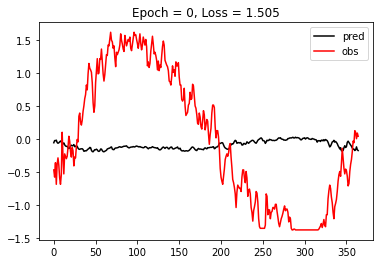

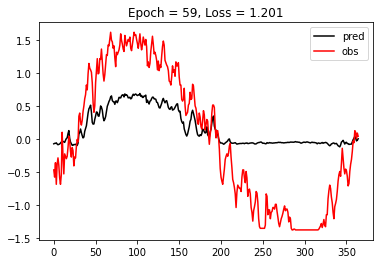

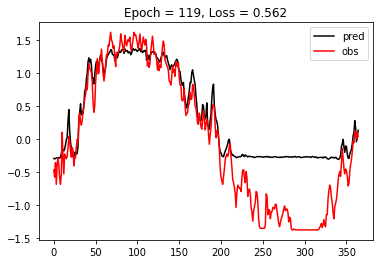

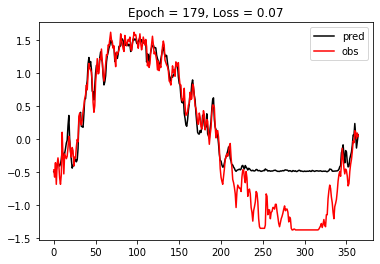

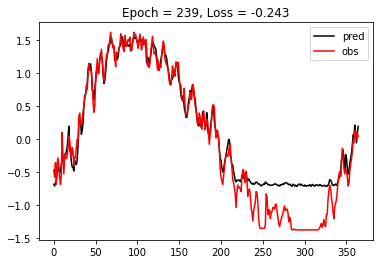

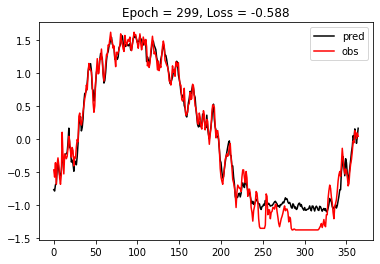

In [6]:
for i in range(300):
    out = model(x)
    loss = loss_fn(y, out)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1) % 60 == 0 or i == 0:
        plt.plot(out.detach()[0, :, 0], color = 'black', label = 'pred')
        plt.plot(y[0], color = 'red', label = 'obs')
        plt.title('Epoch = ' + str(i) + ', Loss = ' + str(np.round(loss.item(), 3)))
        plt.legend()
        plt.show()
        plt.pause(0.001)

# Apply XAI

In [7]:
from captum.attr import IntegratedGradients

In [8]:
ig = IntegratedGradients(model)

In [9]:
integrated_gradients = ig.attribute(x, target = (-1, 0))
integrated_gradients.shape

torch.Size([31, 365, 6])

### Explore visualization options

#### Time series of integrated gradient values for the last day's mu

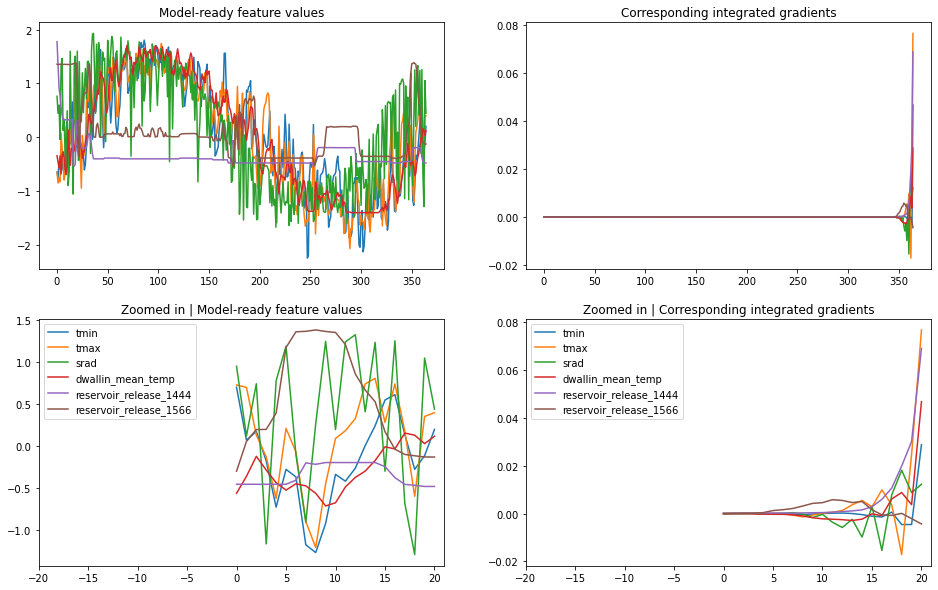

In [10]:
integrated_gradients = ig.attribute(x, target = (-1, 0))

fig, ax = plt.subplots(2, 2, figsize = (16, 10))
ax[0, 0].plot(x[0, :])
ax[0, 0].set_title('Model-ready feature values')
ax[0, 1].plot(integrated_gradients[0, :])
ax[0, 1].set_title('Corresponding integrated gradients')

for var in range(6):
    ax[1, 0].plot(x[0, -21:, var], label = run_pgdl_da['x_vars_trn'][var])
ax[1, 0].set_title('Zoomed in | Model-ready feature values')
ax[1, 0].set_xlim(-20, 21)
ax[1, 0].legend()

for var in range(6):
    ax[1, 1].plot(integrated_gradients[0, -21:, var], label = run_pgdl_da['x_vars_trn'][var])
ax[1, 1].set_title('Zoomed in | Corresponding integrated gradients')
ax[1, 1].set_xlim(-20, 21)
ax[1, 1].legend();

#### Time series of integrated gradient values for the last day's sigma

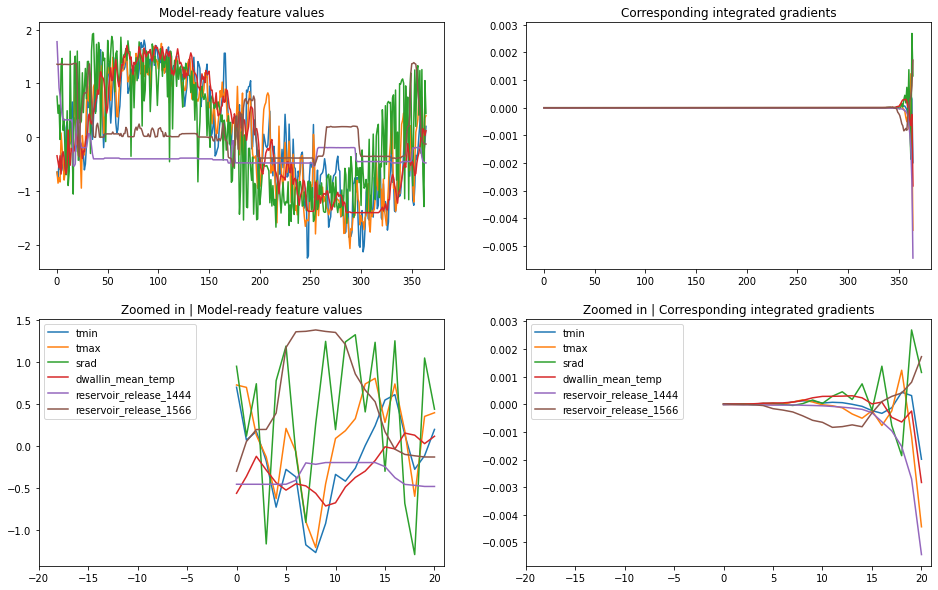

In [11]:
integrated_gradients = ig.attribute(x, target = (-1, 1))

fig, ax = plt.subplots(2, 2, figsize = (16, 10))
ax[0, 0].plot(x[0, :])
ax[0, 0].set_title('Model-ready feature values')
ax[0, 1].plot(integrated_gradients[0, :])
ax[0, 1].set_title('Corresponding integrated gradients')

for var in range(6):
    ax[1, 0].plot(x[0, -21:, var], label = run_pgdl_da['x_vars_trn'][var])
ax[1, 0].set_title('Zoomed in | Model-ready feature values')
ax[1, 0].set_xlim(-20, 21)
ax[1, 0].legend()

for var in range(6):
    ax[1, 1].plot(integrated_gradients[0, -21:, var], label = run_pgdl_da['x_vars_trn'][var])
ax[1, 1].set_title('Zoomed in | Corresponding integrated gradients')
ax[1, 1].set_xlim(-20, 21)
ax[1, 1].legend();

#### Time series of integrated gradient values for the 180th day's mu

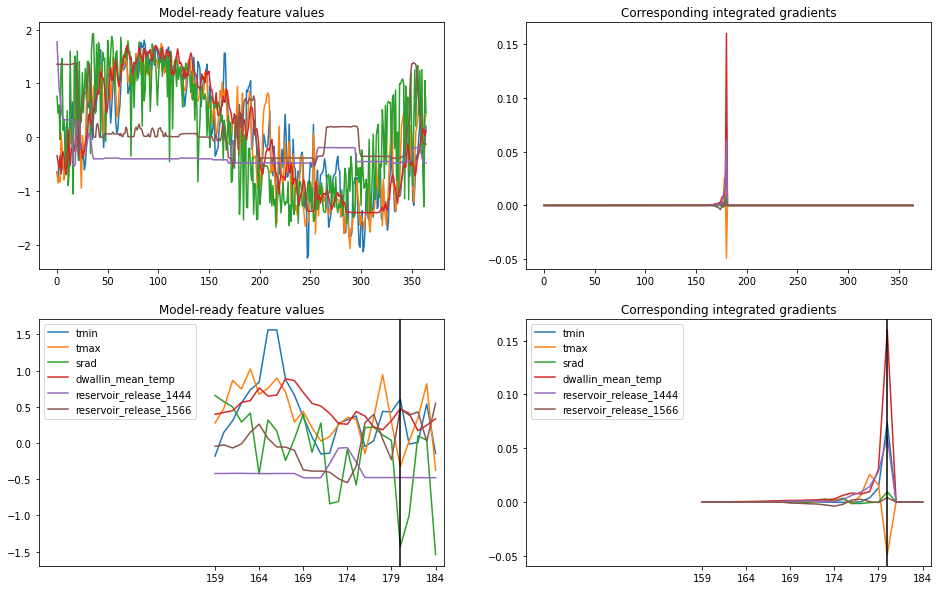

In [12]:
integrated_gradients = ig.attribute(x, target = (180, 0))

fig, ax = plt.subplots(2, 2, figsize = (16, 10))
ax[0, 0].plot(x[0, :])
ax[0, 0].set_title('Model-ready feature values')
ax[0, 1].plot(integrated_gradients[0, :])
ax[0, 1].set_title('Corresponding integrated gradients')

for var in range(6):
    ax[1, 0].plot(x[0, (180-21):185, var], label = run_pgdl_da['x_vars_trn'][var])
ax[1, 0].set_title('Model-ready feature values')
ax[1, 0].set_xlim(-20, 26)
ax[1, 0].set_xticks(np.arange(0, 26, 5), np.arange(180-21,185,5))
ax[1, 0].axvline(x = 21, color = 'black')
ax[1, 0].legend()

for var in range(6):
    ax[1, 1].plot(integrated_gradients[0, 180-21:185, var], label = run_pgdl_da['x_vars_trn'][var])
ax[1, 1].set_title('Corresponding integrated gradients')
ax[1, 1].set_xlim(-20, 26)
ax[1, 1].set_xticks(np.arange(0, 26, 5), np.arange(180-21,185,5))
ax[1, 1].axvline(x = 21, color = 'black')
ax[1, 1].legend();

#### Time series of integrated gradient values for the 180th day's sigma

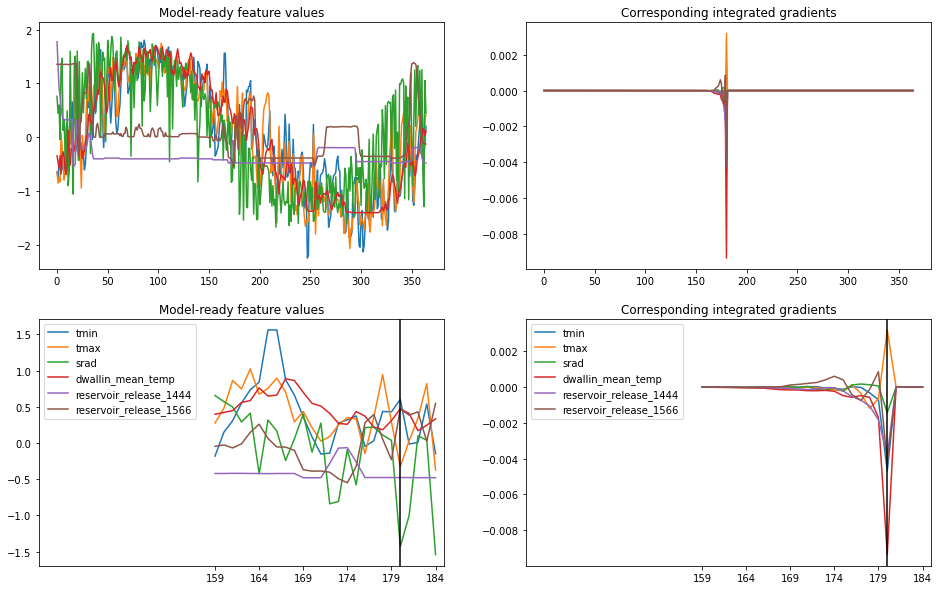

In [13]:
integrated_gradients = ig.attribute(x, target = (180, 1))

fig, ax = plt.subplots(2, 2, figsize = (16, 10))
ax[0, 0].plot(x[0, :])
ax[0, 0].set_title('Model-ready feature values')
ax[0, 1].plot(integrated_gradients[0, :])
ax[0, 1].set_title('Corresponding integrated gradients')

for var in range(6):
    ax[1, 0].plot(x[0, (180-21):185, var], label = run_pgdl_da['x_vars_trn'][var])
ax[1, 0].set_title('Model-ready feature values')
ax[1, 0].set_xlim(-20, 26)
ax[1, 0].set_xticks(np.arange(0, 26, 5), np.arange(180-21,185,5))
ax[1, 0].axvline(x = 21, color = 'black')
ax[1, 0].legend()

for var in range(6):
    ax[1, 1].plot(integrated_gradients[0, 180-21:185, var], label = run_pgdl_da['x_vars_trn'][var])
ax[1, 1].set_title('Corresponding integrated gradients')
ax[1, 1].set_xlim(-20, 26)
ax[1, 1].set_xticks(np.arange(0, 26, 5), np.arange(180-21,185,5))
ax[1, 1].axvline(x = 21, color = 'black')
ax[1, 1].legend();

#### Time series of integrated gradient values for the 180th day's pi (a constant here)

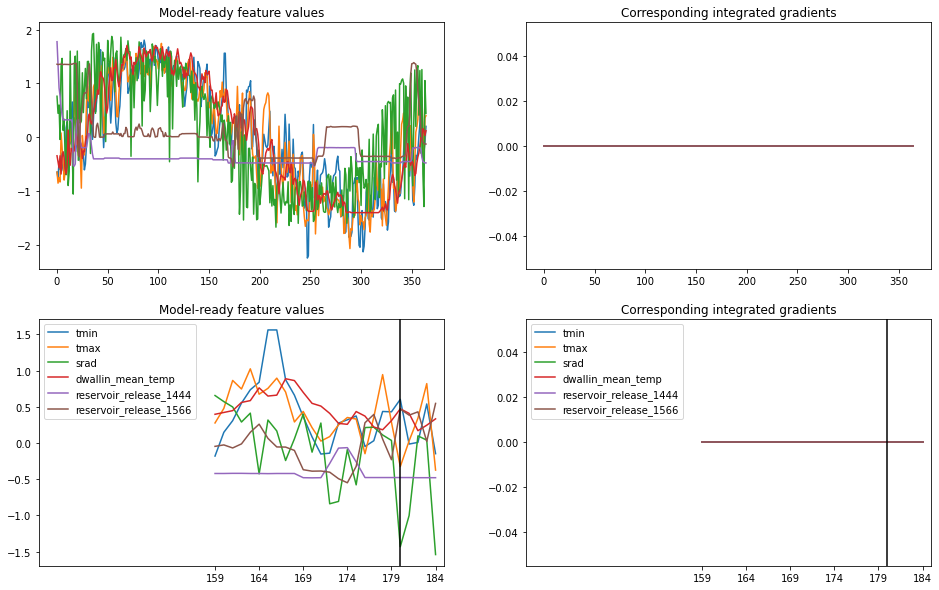

In [14]:
integrated_gradients = ig.attribute(x, target = (180, 2))

fig, ax = plt.subplots(2, 2, figsize = (16, 10))
ax[0, 0].plot(x[0, :])
ax[0, 0].set_title('Model-ready feature values')
ax[0, 1].plot(integrated_gradients[0, :])
ax[0, 1].set_title('Corresponding integrated gradients')

for var in range(6):
    ax[1, 0].plot(x[0, (180-21):185, var], label = run_pgdl_da['x_vars_trn'][var])
ax[1, 0].set_title('Model-ready feature values')
ax[1, 0].set_xlim(-20, 26)
ax[1, 0].set_xticks(np.arange(0, 26, 5), np.arange(180-21,185,5))
ax[1, 0].axvline(x = 21, color = 'black')
ax[1, 0].legend()

for var in range(6):
    ax[1, 1].plot(integrated_gradients[0, 180-21:185, var], label = run_pgdl_da['x_vars_trn'][var])
ax[1, 1].set_title('Corresponding integrated gradients')
ax[1, 1].set_xlim(-20, 26)
ax[1, 1].set_xticks(np.arange(0, 26, 5), np.arange(180-21,185,5))
ax[1, 1].axvline(x = 21, color = 'black')
ax[1, 1].legend();